In [17]:
import os
import torch
import pickle
import numpy as np
import torch.nn as nn
import matplotlib as mpl
from scipy import interpolate
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import rcParams
from captum.attr import GradientShap
from scipy.signal import savgol_filter
from matplotlib.ticker import MultipleLocator
from torch.utils.data import Dataset, DataLoader
from utils import *
from qs_vae import *
from utils_features import *
from utils_attributions import *
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.seterr(divide='ignore', invalid='ignore');
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

#### <font color='dodgerblue'>Content</font>
In this notebook we use an ensemble of trained models to calculate the average attribution maps for IRIS spectrograms. The notebook makes use of the functionality provided by the ***utils_attributions.py*** library. One can select a unique split of the train/test datasets by specifying the fold (see ***Train_ConvNet.ipynb*** for details). We select fold 40 which had a high TSS score and robust statistics to produce attribution maps using both ***Grad-CAM*** and ***Expected Gradients***.  

#### VAE for cleaning QS spectra

In [18]:
encoder = Encoder()
decoder = Decoder()
vae_model = VAE(encoder, decoder).to(device)
vae_model.load_state_dict(torch.load('/data1/userspace/bpanos/multiline/vae/qs_vae_MgII.pt'))
vae_model.eval();

***Process obs***  
Load lvl3C processed data from IRISreader. For details see https://github.com/i4Ds/IRISdataset. The ***process_obs*** function then provides a series of additional cleaning steps and returns:    
***data*** $\to$ (step, raster, y, lambda)  
***nprof_orig*** $\to$ reshape data into (i, wavelength)  
***nprof_clean*** $\to$ bad spectra have been replaced by vectors of nans according to the following three criterion 1) If a spectrum has one or more nan values, 2) if the pseudo continuum between 2799.7-2800.2 is more or equal to 40 % the maximum profile value, and 3) if the reconstruction error from the QS VAE is too low (see ***process_obs*** for details) 

In [19]:
obs = 'FL_20140910_112825_3860259453'
nprof_orig, data = process_obs(vae_model, f"/data1/iris_level_2C_10DNs/{obs}.npz", mode='Raw')
_, nprof_clean = process_obs(vae_model, f"/data1/iris_level_2C_10DNs/{obs}.npz", mode='clean')

#### <font color='dodgerblue'>Grad-CAM</font>

***Select spectrogram to analyze***  
Choose between 50 models trained over 30 epoch each (***ensemble*** folder) or 100 epoch (***ensemble2*** folder) 

In [4]:
fold = 44 # model corresponding to a particular test/train split of the observations
path_to_models = f'/data1/userspace/bpanos/XAI/models/ensembl/{fold}/' # location to ensemble of trained models

***Select one of three options for optim_type if using "ensembl2"***  
1) ***val*** draws out all models in the ensemble that have the lowest validation loss  
2) ***last*** draws out all model states at the last epoch regardless of performance  
3) ***av*** draws out all models with the lowest average loss of train + validation   
***If using "ensemble" all models are simply saved as int.pt (min validation loss)*** 

In [5]:
optim_type = '.pt'
all_model_names = os.listdir(path_to_models)
model_names = list(filter(lambda name: optim_type in name, all_model_names))
model_paths = [ path_to_models + name for name in model_names ]

***Select a spectrogram from obs***

In [6]:
step = 0 # raster step
y_pix = 400 # pixel choice for the spectrogram
spec_ind = 195 # index of spectrum to plot from the spectrogram
nprof_slice = data[step,:,y_pix,:]

In [7]:
heatmaps = []
y_raws = []
for spectrum in tqdm(nprof_slice):
    heatmap = []
    y_raw = []
    for path in model_paths:
        model = CNN(num_classes=2)
        model.load_state_dict(torch.load(path))
        model.to(device)
        model.eval();
        y, y_hat, heat = GC_attributions(spectrum, model) # attributions of single spectrum are calculated here
        heatmap.append(heat)
        y_raw.append(y)
        del model
    heatmap = np.vstack(heatmap)
    heatmap = np.nanmean(heatmap, axis=0)
    heatmaps.append(heatmap)
    y_raws.append(np.nanmean(y_raw))
heatmap = np.flip(np.transpose(heatmaps),0)
heatmap = np.flip(heatmap,0)
y_raw = y_raws/np.nanmax(y_raws)
y_raw = torch.Tensor(y_raw)
y_raw = y_raw.expand(data.shape[3],-1)
y_raw = y_raw.numpy()

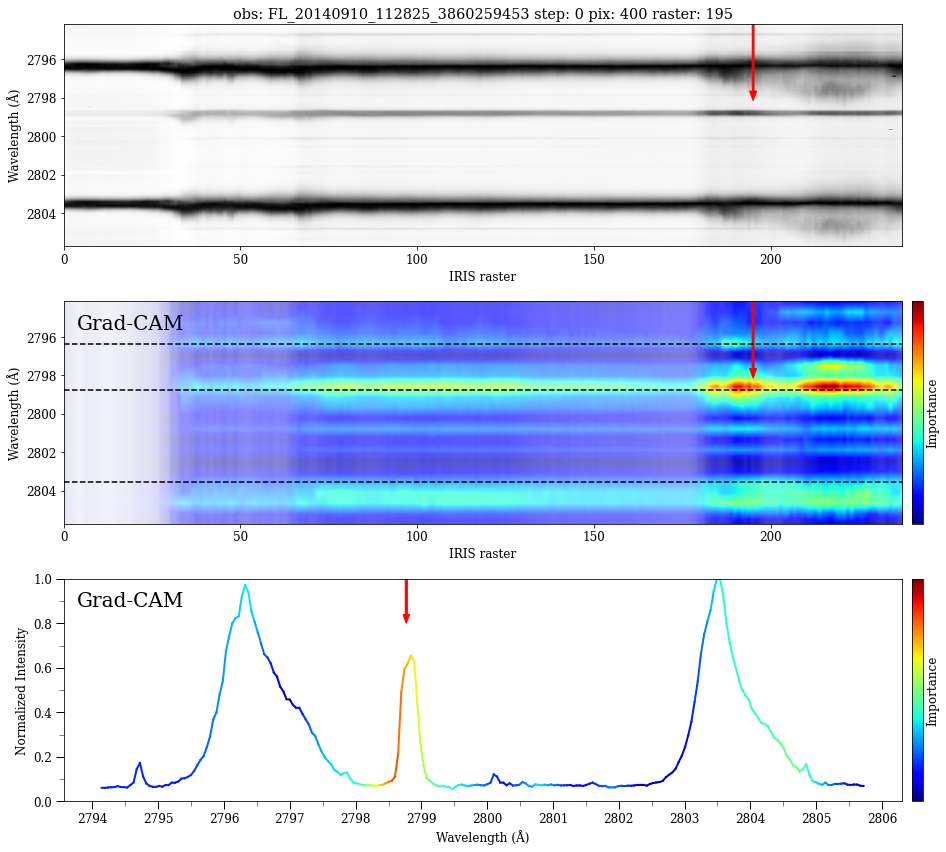

In [8]:
plot_shap_spectrogram(nprof_slice, heatmap, y_raw,
                      method='Grad-CAM',
                      fold=44,
                      obs=obs,
                      pix=y_pix,
                      spec_ind=spec_ind)

#### <font color='dodgerblue'>Expected Gradients </font>

In [9]:
fold = 44 # model corresponding to a particular test/train split of the observations
degree_of_smooth = 41 # post-hoc smooth of attributions
baseline_samples = 500 # number of background data used to calculate attributions
path_to_models = f'/data1/userspace/bpanos/XAI/models/ensembl/{fold}/' # location to ensemble of trained models

***Select one of three options for optim_type if using "ensembl2"***  
1) ***val*** draws out all models in the ensemble that have the lowest validation loss  
2) ***last*** draws out all model states at the last epoch regardless of performance  
3) ***av*** draws out all models with the lowest average loss of train + validation   
***If using "ensemble" all models are simply saved as int.pt (min validation loss)*** 

In [10]:
optim_type = '.pt'
all_model_names = os.listdir(path_to_models)
model_names = list(filter(lambda name: optim_type in name, all_model_names))
model_paths = [ path_to_models + name for name in model_names ]

***Create a baseline***  
Generate a dataset of spectra to be used as a baseline. We read in matrices of cleaned spectra according to a specific "fold" token, indicating which obs are to be used in the test and training datasets. The final output is a PyTorch Tensor ***baseline*** (i, 1, lambda)

In [11]:
with open(f'/data1/userspace/bpanos/XAI/models/ConvNet/{fold}.p', 'rb') as f: dic = pickle.load(f)
path_to_clean_data = '/data1/userspace/bpanos/XAI/data/ConvNet/clean_strong/'
train_obs = dic['train_obs']
AR_train = []
PF_train = []
for n in train_obs:
    if 'AR' in n:
        AR_train.append(n)
    if 'PF' in n:
        PF_train.append(n)
X_train_AR = None
X_train_PF = None
for AR_file, PF_file in zip(AR_train, PF_train):
    fhand = np.load(path_to_clean_data + AR_file)
    X_AR = fhand['X']
    try: X_train_AR = np.concatenate( (X_train_AR, X_AR), axis=0 )
    except: X_train_AR = X_AR
    fhand = np.load(path_to_clean_data + PF_file)
    X_PF = fhand['X']
    try: X_train_PF = np.concatenate( (X_train_PF, X_PF), axis=0 )
    except: X_train_PF = X_PF
X_train_AR, X_train_PF = Balance(X_train_AR, X_train_PF)
y_train_AR = np.zeros(len(X_train_AR))
y_train_PF = np.ones(len(X_train_PF))
X_train = np.concatenate((X_train_AR, X_train_PF), axis=0)
y_train = np.concatenate((y_train_AR, y_train_PF))
baseline = torch.Tensor(X_train).to(device).unsqueeze(1)

***Select a spectrogram from obs***

In [12]:
step = 0 # raster step
y_pix = 400 # pixel choice for the spectrogram
spec_ind = 195 # index of spectrum to plot from the spectrogram
nprof_slice = data[step,:,y_pix,:]

In [13]:
heatmaps = []
y_raws = []
for spectrum in tqdm(nprof_slice):
    heatmap = []
    y_raw = []
    for path in model_paths:
        model = CNN(num_classes=2)
        model.load_state_dict(torch.load(path))
        model.to(device)
        model.eval();
        # attributions of single spectrum are calculated here
        y, y_hat, heat = EG_attributions(spectrum, baseline, model, n_samples=baseline_samples, degree_of_smooth=degree_of_smooth)
        heatmap.append(heat)
        y_raw.append(y)
        del model
    heatmap = np.vstack(heatmap)
    heatmap = np.nanmean(heatmap, axis=0)
    heatmaps.append(heatmap)
    y_raws.append(np.nanmean(y_raw))
heatmap = np.flip(np.transpose(heatmaps),0)
heatmap = np.flip(heatmap,0)
y_raw = y_raws/np.nanmax(y_raws)
y_raw = torch.Tensor(y_raw)
y_raw = y_raw.expand(data.shape[3],-1)
y_raw = y_raw.numpy()

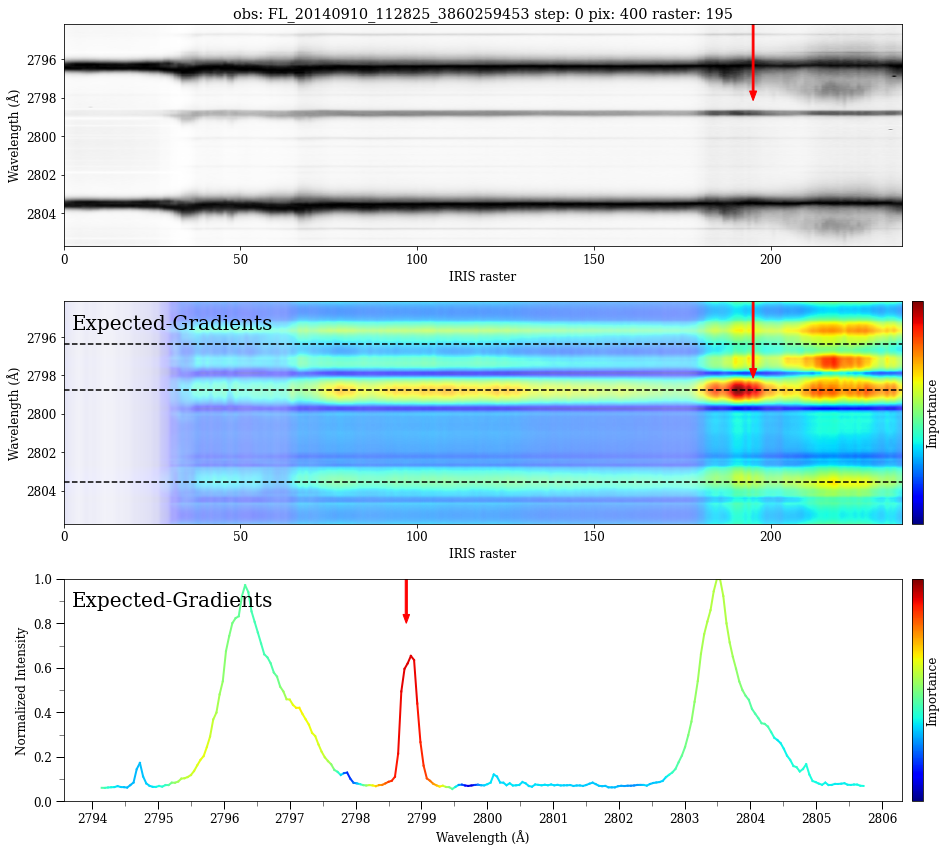

In [16]:
plot_shap_spectrogram(nprof_slice, heatmap, y_raw,
                      method='Expected-Gradients',
                      fold=44,
                      obs=obs,
                      pix=y_pix,
                      spec_ind=spec_ind)

***Interpreting plots***: Important attributions are colored red while less important attributions blue. The color is determined by:  
1. The ***attribution score***, as calculated per-spectrum either using the Grad-CAM or Expected Gradients formalism 
2. The model score ***y_hat*** per spectrum, which is distributed proportionaly over the spectrum's attributions. This means that spectra with low scores will never be colored red  
3. The ***reference pixel***, which is a single pixel in the spectrogram that is artificially set to a value of 1/len(spectrum) to provide a reference. This allows us to compare different spectrograms since otherwise pythons imshow would always normalize to the maximum of the data

Although this is a flare observation, we can clearly see with both attribution methods that the triplet emission is a critical feature for the models decision and classification into the PF-class

***Calculate all spectograms***  
And store y_hat, y_raw, attributions ... 